In [1]:
import fastf1 as ff1
ff1.Cache.enable_cache('/Users/shivanireddy/Desktop/dataclasses/datastudio/project2/cache')  
race = ff1.get_session(2022, 'Brazil', 'R')


In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings


situation       INFO 	cffi mode is CFFI_MODE.ANY
situation       INFO 	R home found: /opt/homebrew/Cellar/r/4.2.2/lib/R
situation       INFO 	R library path: 
situation       INFO 	LD_LIBRARY_PATH: 
embedded       INFO 	Default options to initialize R: rpy2, --quiet, --no-save
embedded       INFO 	R is already initialized. No need to initialize.


In [3]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML


In [4]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
%%R

require('tidyverse')

callbacks    WARNING 	R[write to console]: Loading required package: tidyverse



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [6]:
import seaborn as sns
import requests
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [7]:
#using ergast API for race championship stats
def ergast_retrieve(api_endpoint: str):
    url = f'https://ergast.com/api/f1/{api_endpoint}.json'
    response = requests.get(url).json()
    
    return response['MRData']

In [8]:
ergast_retrieve('current/1/driverStandings')

{'xmlns': 'http://ergast.com/mrd/1.5',
 'series': 'f1',
 'url': 'http://ergast.com/api/f1/current/1/driverstandings.json',
 'limit': '30',
 'offset': '0',
 'total': '20',
 'StandingsTable': {'season': '2022',
  'round': '1',
  'StandingsLists': [{'season': '2022',
    'round': '1',
    'DriverStandings': [{'position': '1',
      'positionText': '1',
      'points': '26',
      'wins': '1',
      'Driver': {'driverId': 'leclerc',
       'permanentNumber': '16',
       'code': 'LEC',
       'url': 'http://en.wikipedia.org/wiki/Charles_Leclerc',
       'givenName': 'Charles',
       'familyName': 'Leclerc',
       'dateOfBirth': '1997-10-16',
       'nationality': 'Monegasque'},
      'Constructors': [{'constructorId': 'ferrari',
        'url': 'http://en.wikipedia.org/wiki/Scuderia_Ferrari',
        'name': 'Ferrari',
        'nationality': 'Italian'}]},
     {'position': '2',
      'positionText': '2',
      'points': '18',
      'wins': '0',
      'Driver': {'driverId': 'sainz',
      

In [9]:
rounds = 22

all_championship_standings = pd.DataFrame()

# We also want to store which driver drives for which team, which will help us later
driver_team_mapping = {}

# Initate a loop through all the rounds
for i in range(1, rounds + 1):
    # Make request to driverStandings endpoint for the current round
    race = ergast_retrieve(f'current/{i}/driverStandings')
    
    # Get the standings from the result
    standings = race['StandingsTable']['StandingsLists'][0]['DriverStandings']
    
    # Initiate a dictionary to store the current rounds' standings in
    current_round = {'round': i}
    
    # Loop through all the drivers to collect their information
    for i in range(len(standings)):
        driver = standings[i]['Driver']['code']
        position = standings[i]['position']
        
        # Store the drivers' position
        current_round[driver] = int(position)
        
        # Create mapping for driver-team to be used for the coloring of the lines
        driver_team_mapping[driver] = standings[i]['Constructors'][0]['name']


    # Append the current round to our fial dataframe
    all_championship_standings = all_championship_standings.append(current_round, ignore_index=True)
    
# Set the round as the index of the dataframe
all_championship_standings = all_championship_standings.set_index('round')


In [10]:
all_championship_standings 
all_championship_standings.drop('HUL', axis=1, inplace=True)

In [11]:
#all_championship_standings 

In [12]:
all_championship_standings_melt = pd.melt(all_championship_standings.reset_index(), ['round'])

In [19]:
#making the editorial decision to drop Nico Hulkenberg (HUL) from the data. He was a reserve driver that filled in for Sebastian Vettel for the first two races when Vettel had Covid, but he earned no points. Vettel came in from round 3 onwards.
#However, we're keeping Nick De Vries (DEV), the driver who filled in for Alex Albon in Monza when Albon had appendicitis, because of the significance of his performance. He earned points on debut!
#all_championship_standings_melt
#all_championship_standings_melt.drop(index=373, axis=0)

In [1]:
#all_championship_standings_melt

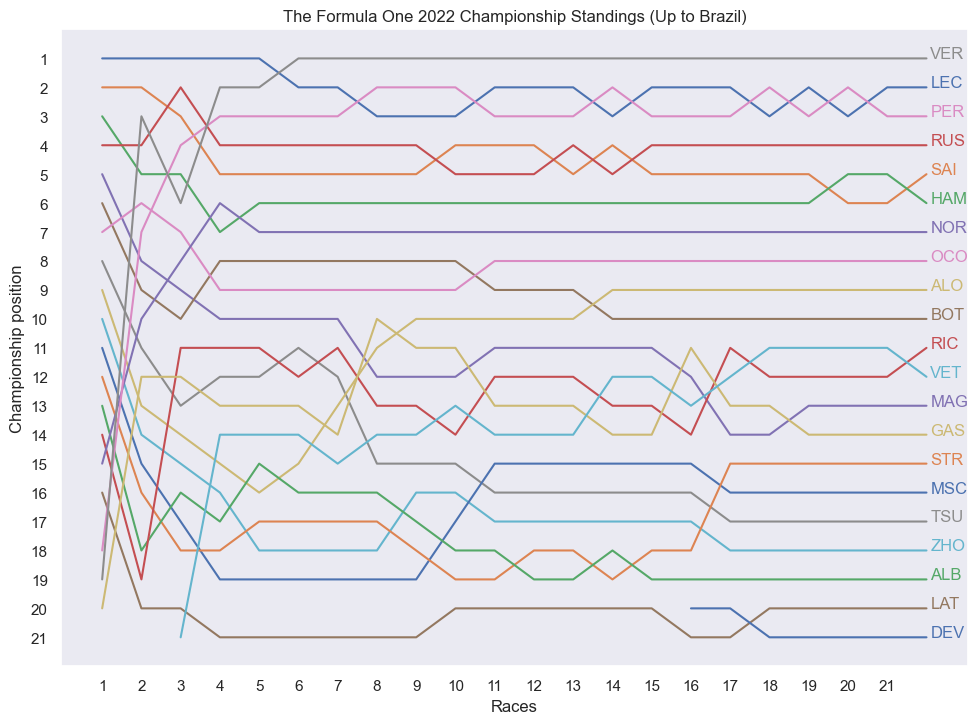

In [20]:

# Increase the size of the plot 
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Initiate the plot
fig, ax = plt.subplots()

# Set the title of the plot
ax.set_title("The Formula One 2022 Championship Standings (Up to Brazil)")

# Draw a line for every driver in the data by looping through all the standings
# The reason we do it this way is so that we can specify the team color per driver
for driver in pd.unique(all_championship_standings_melt['variable']):
    sns.lineplot(
        x='round', 
        y='value', 
        data=all_championship_standings_melt.loc[all_championship_standings_melt['variable']==driver])

# Invert Y-axis to have championship leader (#1) on top
ax.invert_yaxis()

# Set the values that appear on the x- and y-axes
ax.set_xticks(range(1, rounds))
ax.set_yticks(range(1, 22))

# Set the labels of the axes
ax.set_xlabel("Races")
ax.set_ylabel("Championship position")

# Disable the gridlines 
ax.grid(False)


# Add the driver name to the lines
for line, name in zip(ax.lines, all_championship_standings.columns.tolist()):
    y = line.get_ydata()[-1]
    x = line.get_xdata()[-1]
        
    text = ax.annotate(
        name,
        xy=(x + 0.1, y),
        xytext=(0, 0),
        color=line.get_color(),
        xycoords=(
            ax.get_xaxis_transform(),
            ax.get_yaxis_transform()
        ),
        textcoords="offset points"
    )

# Save the plot
plt.savefig('standings.svg')
